<img width="100" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# Exploring additional tonyear approaches implemented by the Climate Action Reserve and the government of Quebec

_by Freya Chay (CarbonPlan)_

This notebook introduces our implementation of the ton-year methods used by the Climate Action
Reserve (CAR) and proposed by the government of Quebec (QC).

We also compare the replicated methods to the implementation of the Lashof method in the `tonyear`
package.

Sources:

- [Climate Action Reserve Soil Enrichment Protocol (2020)](https://www.climateactionreserve.org/wp-content/uploads/2020/10/Soil-Enrichment-Protocol-V1.0.pdf)
- [Quebec draft ton-year methodology (2021)](https://www.environnement.gouv.qc.ca/changements/carbone/credits-compensatoires/quebec-protocole-foret-en.pdf)


In [14]:
%load_ext watermark
%matplotlib inline

import math

import numpy as np
import matplotlib.pyplot as plt

import tonyear

from carbonplan import styles
styles.mpl.set_theme(style='carbonplan_light', font_scale=1.25)

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [15]:
%watermark -u -i -v -m -g -iv

Last updated: 2023-05-03T17:05:13.115601+00:00

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.4.226-129.415.amzn2.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

Git hash: bbe2bddbd87af0f7ffb1b3e3b75a922d65fc9b8b

tonyear   : 1.1.0
carbonplan: 0.5.0
numpy     : 1.21.3
matplotlib: 3.4.3



## Comparing the CAR and Quebec methods to Lashof


If you aren't familiar with the Lashof method or the concept of an 'equivalence ratio', please take
a minute to check out our
[ton-year explainer article](https://carbonplan.org/research/ton-year-explainer). In brief, the
equivalence ratio describes how many tons of CO₂ need to be temporarily stored to justify an
additional ton of CO₂ emitted to the atmosphere today under a given set of assumptions.

The Lashof method calculates the benefit of temporary carbon storage by asking how many ton-years of
atmospheric impact are avoided as a result of the carbon storage. To do so, the Lashof method looks
looks both at the ton-year benefit of the carbon storage and at the ton-year cost of re-emission
after the storage period ends.

Neither the CAR nor Quebec methods explicitly consider the ton-year cost of re-emission. We can
compare the equivalence ratios generated by these methods to the equivalence ratios generated by the
Lashof method get a sense of how much temporary carbon storage might be overvalued as a result.

Both the CAR and Quebec methods are explored in more detail below.


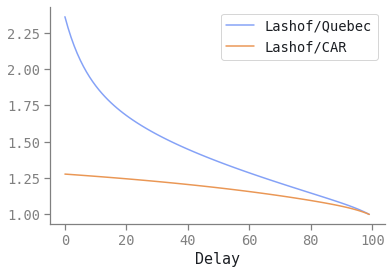

In [4]:
curve = tonyear.get_baseline_curve("joos_2013")
delays = np.arange(1, 101)
time_horizon = 100
discount_rate = 0

equivalence_lashof = [
    tonyear.calculate_tonyears("lashof", curve, time_horizon, delay, discount_rate)[
        "num_for_equivalence"
    ]
    for delay in delays
]
equivalence_car = [
    tonyear.calculate_tonyears("car", curve, time_horizon, delay, discount_rate)[
        "num_for_equivalence"
    ]
    for delay in delays
]
equivalence_qc = [
    tonyear.calculate_tonyears("qc", curve, time_horizon, delay, discount_rate)[
        "num_for_equivalence"
    ]
    for delay in delays
]

plt.plot(np.array(equivalence_lashof) / np.array(equivalence_qc), label="Lashof/Quebec")
plt.plot(np.array(equivalence_lashof) / np.array(equivalence_car), label="Lashof/CAR")

plt.xlabel("Delay")
plt.legend()
plt.show()

While all three methods converge on 100 years of carbon storage being equivalent to a 1 tCO2
emission, they diverge for shorter storage periods.

The Quebec method, in particular, values temporary storage more than the Lashof method — and the
shorter the storage period, the more significant the difference. This effect occurs because the
Quebec method focuses on the “benefit” of avoiding radiative forcing over the storage period, but
does not take into account the radiative forcing “cost” that occurs when CO2 is reemitted at the end
of the storage period. (The Lashof method more appropriately counts both elements.)

To give a more specific example, we can compare how tCO2 stored for 1 year each method would require
for equivalence.


In [5]:
print(f"Lashof requires:   {round(equivalence_lashof[0])} tCO2 stored for 1 year")
print(f"CAR requires:      {round(equivalence_car[0])} tCO2 stored for 1 year")
print(f"Quebec requires:   {round(equivalence_qc[0])} tCO2 stored for 1 year")
print()

Lashof requires:   128 tCO2 stored for 1 year
CAR requires:      100 tCO2 stored for 1 year
Quebec requires:   54 tCO2 stored for 1 year



## The Climate Action Reserve method


The Climate Action Reserve (CAR) ton-year method calculates the benefit of temporary carbon storage
by (1) defining the duration of carbon storage considered equivalent to an emission and (2) awarding
proportional credit linearly over the time horizon for more temporary storage.

CAR specifically defines 100 year storage as "completely mitigat[ing] an equal GHG emission
elsewhere." In other words, CAR claims that storing 1 tCO2 for 100 years (100 ton-years of storage)
is equivalent to a 1 tCO2 emission. Storing 1 tCO2 for 1 years (1 ton-years) would only provide
1/100th of the benefit needed for equivalence. Similarly, storing 1 tCO2 for 20 years (20 ton-years)
would provide 1/5th of the benefit needed for equivalence.

The CAR ton year accounting method is in the Soil Enrichment Protocol (V1) in section 3.5.5:
https://www.climateactionreserve.org/wp-content/uploads/2020/10/Soil-Enrichment-Protocol-V1.0.pdf

We show two examples of the `tonyear` module's calculations below for CAR's method with a 100 year
time horizon.


In [6]:
time_horizon = 100
discount_rate = 0
delay = 1
baseline = tonyear.get_baseline_curve("joos_2013")

tonyear.print_benefit_report(
    tonyear.calculate_tonyears("car", baseline, time_horizon, delay, discount_rate)
)


Discount rate: 0%
Delay: 1 year(s)
Baseline atmospheric cost: 52.36 ton-years
Benefit from 1tCO2 with delay: 0.52 ton-years
Number needed: 100.0



In [7]:
time_horizon = 100
discount_rate = 0
delay = 30
baseline = tonyear.get_baseline_curve("joos_2013")

tonyear.print_benefit_report(
    tonyear.calculate_tonyears("car", baseline, time_horizon, delay, discount_rate)
)


Discount rate: 0%
Delay: 30 year(s)
Baseline atmospheric cost: 52.36 ton-years
Benefit from 1tCO2 with delay: 15.71 ton-years
Number needed: 3.3



In essence, the CAR method awards benefit linearly over the chosen time_horizon.


## Proposed Quebec method


The governement of Quebec (specifically the Ministère de l’Environnement et de la Lutte contre les
changements climatiques) allows afforestation and reforestation projecst to be credited using a ton-year accounting method. The  method calculates the benefit of temporary carbon storage by (1) defining the duration of carbon storage considered equivalent to an emission (100 years) and (2) awarding credit over the time horizon in proportion to the shape of the IRF curve.

The Quebec method is described in a slide deck presenting the draft ton-year accounting approach:
https://www.environnement.gouv.qc.ca/changements/carbone/credits-compensatoires/quebec-protocole-foret-en.pdf

The regulator additionally provides an excel calculator for project to execute ton-year accounting calculations (see [the Calculator of the balance of the radiative effect and the number of offset credits to be issued relating to the realization of an afforestation and reforestation project](https://www-environnement-gouv-qc-ca.translate.goog/changements/carbone/credits-compensatoires/sequestration-carbone-boisement-reboisement-terres-prive.htm?_x_tr_sl=auto&_x_tr_tl=en&_x_tr_hl=en&_x_tr_pto=wapp#outils).

We show an example of the `tonyear` module's implementation of Quebec method below, replicating the result in the draft methodology (see Slide 8). 


In [3]:
time_horizon = 100
discount_rate = 0
delay = 30
baseline = tonyear.get_baseline_curve("joos_2013")

qc = tonyear.calculate_tonyears("qc", baseline, time_horizon, delay, discount_rate)
tonyear.print_benefit_report(qc)
percent_credit = round(qc["benefit"] / qc["baseline_atm_cost"], 1)
print(
    f"--> {qc['parameters']['delay']} year delay corresponds to {percent_credit*100}% of a credit"
)
print()


Discount rate: 0%
Delay: 30 year(s)
Baseline atmospheric cost: 52.36 ton-years
Benefit from 1tCO2 with delay: 19.96 ton-years
Number needed: 2.6

--> 30 year delay corresponds to 40.0% of a credit



In essence, the Quebec method awards benefit in proportion to the shape of the IRF curve used to
approximate the radiative forcing effect resulting from a CO2 emission in the atmosphere.

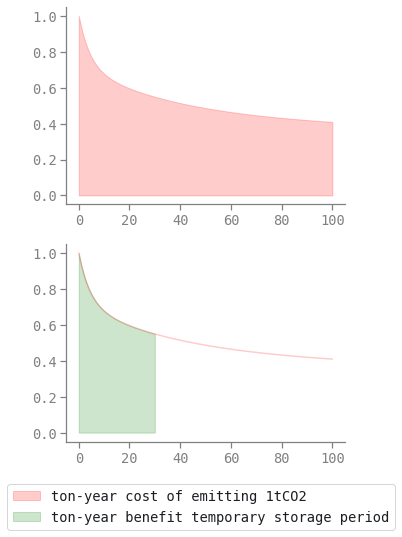

In [4]:
t = np.arange(qc["parameters"]["time_horizon"] + 1)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5, 8))

ax[0].fill_between(
    t,
    qc["baseline"],
    color="red",
    alpha=0.2,
    label="ton-year cost of emitting 1tCO2",
)

delay = qc["parameters"]["delay"]
time_horizon = qc["parameters"]["time_horizon"]

ax[1].plot(qc["baseline"], color="red", alpha=0.2)
ax[1].fill_between(
    t,
    qc["baseline"],
    where=(t <= qc["parameters"]["delay"]),
    color="green",
    alpha=0.2,
    label="ton-year benefit temporary storage period",
)

handles = []
labels = []
for ax in fig.axes:
    ax_handles, ax_labels = ax.get_legend_handles_labels()
    handles.extend(ax_handles)
    labels.extend(ax_labels)
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.04))
plt.show()

We can also compare the results from our implentation of Quebec's ton-year method against the excel tool provided by the regulator for the following innput parameters (provided by Claude Fortin at the Quebec Regulator): 

- Debut (start): 2023
- Fin (end): 2123
- Réservoir "Total Écosystème" tiré du MBC-SFC (tC): 
    - year 0: 0 tC
    - year 1: 27.272727 tC (100 tCO2)
    
The results from the Quebec excel tool describe the number of credits issued every 5 years from 2023 to 2123, with credits issued rounded to the nearest whole number:
    
|       | Périodes de déclaration |      |  |  |  |                        |     |
|-------|-------------------------|------|--|--|--|------------------------|-----|
|       | Début                   | Fin  |  |  |  | Crédits compensatoires |     |
| No 1  | 2023                    | 2028 |  |  |  | 10                     | CrC |
| No 2  | 2029                    | 2033 |  |  |  | 7                      | CrC |
| No 3  | 2034                    | 2038 |  |  |  | 6                      | CrC |
| No 4  | 2039                    | 2043 |  |  |  | 6                      | CrC |
| No 5  | 2044                    | 2048 |  |  |  | 6                      | CrC |
| No 6  | 2049                    | 2053 |  |  |  | 5                      | CrC |
| No 7  | 2054                    | 2058 |  |  |  | 5                      | CrC |
| No 8  | 2059                    | 2063 |  |  |  | 5                      | CrC |
| No 9  | 2064                    | 2068 |  |  |  | 5                      | CrC |
| No 10 | 2069                    | 2073 |  |  |  | 5                      | CrC |
| No 11 | 2074                    | 2078 |  |  |  | 5                      | CrC |
| No 12 | 2079                    | 2083 |  |  |  | 4                      | CrC |
| No 13 | 2084                    | 2088 |  |  |  | 4                      | CrC |
| No 14 | 2089                    | 2093 |  |  |  | 4                      | CrC |
| No 15 | 2094                    | 2098 |  |  |  | 4                      | CrC |
| No 16 | 2099                    | 2103 |  |  |  | 4                      | CrC |
| No 17 | 2104                    | 2108 |  |  |  | 4                      | CrC |
| No 18 | 2109                    | 2113 |  |  |  | 4                      | CrC |
| No 19 | 2114                    | 2118 |  |  |  | 4                      | CrC |
| No 20 | 2119                    | 2123 |  |  |  | 3                      | CrC |

For easy comparison, we can translate this sequence of credit issuances into a a percent of credits cumulative credits issued for differnt project lengths (5 years, 10 years, 15 years, etc.), and compare that to the results from our ton-year implementation.

In [5]:
qc_issuance = [9.7304611919,
6.6948702387,
6.1289875310,
5.7811556635,
5.5213473781,
5.3063662306,
5.1205094767,
4.9569575752,
4.8119143417,
4.6827419885,
4.5673503464,
4.4639820534,
4.3711246886,
4.2874652728,
4.2118603309,
4.1433128308,
4.0809530262,
4.0240220476,
3.9718576852,
3.1427601021]

In [19]:
qc_percent = np.cumsum(qc_issuance) / sum(qc_issuance)
qc_percent

array([0.09730461, 0.16425331, 0.22554319, 0.28335475, 0.33856822,
       0.39163188, 0.44283698, 0.49240655, 0.5405257 , 0.58735312,
       0.63302662, 0.67766644, 0.72137769, 0.76425234, 0.80637094,
       0.84780407, 0.8886136 , 0.92885382, 0.9685724 , 1.        ])

In [20]:
years = np.arange(2028,2124,5)

time_horizon = 100
discount_rate = 0
baseline = tonyear.get_baseline_curve("joos_2013")

our_results = []

for year in years:

    delay = year - 2022   
    qc = tonyear.calculate_tonyears("qc", baseline, time_horizon, delay, discount_rate)
    percent_credits = qc["benefit"] / qc["baseline_atm_cost"]
    our_results.append(percent_credits)

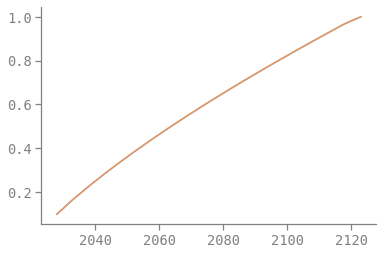

In [22]:
plt.plot(years, qc_percent)
plt.plot(years, our_results)

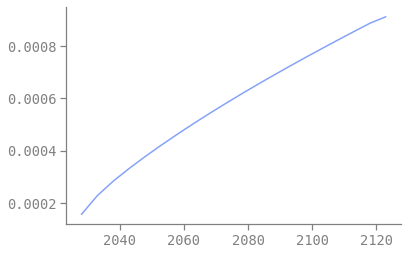

In [106]:
plt.plot(years, np.subtract(our_results, qc_tool))

In [103]:
np.subtract(our_results, qc_tool)

array([0.00015614, 0.00022821, 0.00028365, 0.00033243, 0.00037784,
       0.00042106, 0.00046258, 0.00050268, 0.00054154, 0.0005793 ,
       0.00061608, 0.00065198, 0.00068711, 0.00072153, 0.00075531,
       0.00078852, 0.00082121, 0.00085342, 0.0008852 , 0.00091033])

In [5]:
time_horizon = 100
discount_rate = 0
baseline = tonyear.get_baseline_curve("joos_2013")

for delay in [1, 10, 15, 30, 50]:

    qc = tonyear.calculate_tonyears("qc", baseline, time_horizon, delay, discount_rate)
    tonyear.print_benefit_report(qc)
    percent_credit = round(qc["benefit"] / qc["baseline_atm_cost"], 1)
    print(
        f"--> {qc['parameters']['delay']} year delay corresponds to {percent_credit*100}% of a credit"
    )
    print()


Discount rate: 0%
Delay: 1 year(s)
Baseline atmospheric cost: 52.36 ton-years
Benefit from 1tCO2 with delay: 0.97 ton-years
Number needed: 54.1

--> 1 year delay corresponds to 0.0% of a credit


Discount rate: 0%
Delay: 10 year(s)
Baseline atmospheric cost: 52.36 ton-years
Benefit from 1tCO2 with delay: 7.93 ton-years
Number needed: 6.6

--> 10 year delay corresponds to 20.0% of a credit


Discount rate: 0%
Delay: 15 year(s)
Baseline atmospheric cost: 52.36 ton-years
Benefit from 1tCO2 with delay: 11.19 ton-years
Number needed: 4.7

--> 15 year delay corresponds to 20.0% of a credit


Discount rate: 0%
Delay: 30 year(s)
Baseline atmospheric cost: 52.36 ton-years
Benefit from 1tCO2 with delay: 19.96 ton-years
Number needed: 2.6

--> 30 year delay corresponds to 40.0% of a credit


Discount rate: 0%
Delay: 50 year(s)
Baseline atmospheric cost: 52.36 ton-years
Benefit from 1tCO2 with delay: 30.27 ton-years
Number needed: 1.7

--> 50 year delay corresponds to 60.0% of a credit

